In [2]:
#Imports & db connection setup
from modules.preamble import *
from modules.event_data_conversion import get_time_between_events, events_to_rt_pred

#Enter information to access your PostgreSQL MIMIC database from Python
con = psycopg2.connect(dbname='mimic', user='postgres', password='postgres', port=5433) #Your credentials for the database connector
query_schema = 'set search_path to mimiciii;' #Your search path to the MIMIC-III schema

%matplotlib inline

C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\frame

# Notes
In the remainder, we refer to the 3 different strategies in the same manner as in Figure 4.3 of the thesis:

1. No filling
2. Filling with a window size equal to the median time between events for every individual variable
3. Full forward filling (within patients)

<img src='.\notebook_figures\filling-merged.png' style="width: 600px;">

# Loading the data
Including some preliminary cleaning & merging.

In [3]:
#Load datasets from the "Event Tables Filtering" notebook
df_bm = pd.read_hdf(os.path.join(data_base_path, "cleaned_BM_events.hdf"));
df_lt = pd.read_hdf(os.path.join(data_base_path, "cleaned_LT_events.hdf"));

In [4]:
#Drop the at3 variable because it was only measured 4 times in total
df_lt = df_lt[~(df_lt['variable']=='at3')]

In [5]:
#Drop all events with valuenum = NaN. They cannot be used anyway
df_bm = df_bm[~df_bm['valuenum'].isnull()]
df_lt = df_lt[~df_lt['valuenum'].isnull()]

In [6]:
#Concatenate all events into a single dataframe
df = pd.concat([df_bm, df_lt]).reset_index(drop=True)

# Split events in training & testing events
Split events based on patients

In [7]:
df.head()

,row_id,subject_id,hadm_id,itemid,label,variable,charttime,valuenum,valueuom
0,56803,502,116367,223835,inspired o2 fraction,fio2,2143-10-24 00:00:00,100.0,None
1,60868,502,116367,223835,inspired o2 fraction,fio2,2143-10-28 11:00:00,60.0,None
2,59352,502,116367,223835,inspired o2 fraction,fio2,2143-10-26 19:00:00,40.0,None
3,15849,111,155897,223835,inspired o2 fraction,fio2,2144-07-01 13:30:00,100.0,None
4,86666,711,158767,223835,inspired o2 fraction,fio2,2185-03-25 00:00:00,40.0,None


In [8]:
from sklearn.model_selection import train_test_split

random_state=10 #Trial & error with random state such that we approximately get 70% of events in training & 30% in testing

#Select all subjects
all_subjects = df['subject_id'].unique()

#Make a split among subjects, stratified on the target label
train_subj, test_subj = train_test_split(
    all_subjects,
    test_size=0.3,
    random_state=random_state)

In [9]:
#Split the instances for modeling based on the subjects
df_train,df_test = [df[df['subject_id'].isin(train_subj)], df[df['subject_id'].isin(test_subj)]]

#Check if split conforms to requirements
print("Patients in train & test sets:", len(train_subj), len(test_subj))
print("Events in train & test sets:", len(df_train), len(df_test))
print("% of total events in train & test sets",
      len(df_train)/len(df)*100,
      len(df_test)/len(df)*100, "\n")

Patients in train & test sets: 1691 725
Events in train & test sets: 2857213 1297987
% of total events in train & test sets 68.7623459761263 31.237654023873702 



# Preparation
* Get the median time between events for each variable in strategy 1.
* Get the mean and standard deviation for missing value imputation & standardization using the training events. These are used in 1, 2 and 3 later on.
* Inspect statistics on the time between events for each variable

In [10]:
df_tbt = get_time_between_events(df_train[['subject_id', 'charttime', 'variable']], 'median')
max_cfts = df_tbt.to_dict() #Store for later usage

In [11]:
means = df_train.groupby('variable')['valuenum'].mean()
stds = df_train.groupby('variable')['valuenum'].std()

In [12]:
df_tbt = get_time_between_events(df[['hadm_id', 'charttime', 'variable']],
                                 ['mean', 'median', 'std', 'min', 'max'])
df_tbt

,mean,median,std,min,max
variable,,,,,
arterial base excess,0 days 09:15:28.859751438,0 days 04:52:00,1 days 04:15:38.714907836,0 days 00:01:00,89 days 00:16:00.000000001
arterial pco2,0 days 09:15:30.200305687,0 days 04:52:00,1 days 04:15:53.943642057,0 days 00:01:00,89 days 00:16:00.000000001
arterial ph,0 days 09:13:44.737618546,0 days 04:49:00,1 days 05:35:28.182239679,0 days 00:01:00,137 days 01:45:00
arterial po2,0 days 09:15:24.908915430,0 days 04:52:00,1 days 04:15:43.669504320,0 days 00:01:00,89 days 00:16:00.000000001
bicarbonate,0 days 15:22:34.537357559,0 days 13:01:00,0 days 10:13:50.569996945,0 days 00:00:00,25 days 03:29:00
bilirubin,1 days 09:01:57.806608063,0 days 23:50:00,1 days 22:45:13.341769010,0 days 00:03:00,38 days 07:25:00
calcium,0 days 17:06:41.854119067,0 days 14:24:00,0 days 12:58:45.424785010,0 days 00:01:00,21 days 06:25:00
creatinine,0 days 15:41:34.116547805,0 days 13:19:00,0 days 10:01:28.738692465,0 days 00:01:00,25 days 03:29:00
crp,6 days 08:34:45.128205128,4 days 00:15:00,7 days 16:33:00.880888904,0 days 03:25:00,50 days 01:16:00


In [13]:
#FORMAT & EXPORT RESULT TO EXCEL - wish pandas would support .strftime for timedelta types natively....
df_tbt_excel = df_tbt.copy(deep=True)

#Convert columns to strings for correct display in Excel
for col in df_tbt_excel.columns:
    time_components = df_tbt_excel[col].dt.components #Obtain components (days, hours, etc.)
    time_components['seconds_to_add'] = 1*(time_components['milliseconds']>=500) #Determine whether we must add a second when rounding
    time_components['seconds'] = time_components['seconds'] + time_components['seconds_to_add'] #Add the second if required
    time_components = time_components.astype(str) #Convert to string type for further formatting

    #Add zeroes before components if required
    for col1 in ['hours', 'minutes', 'seconds']:
        mask_add_zero_before = time_components[col1].str.len() < 2 #If less than 2 chars, then add a 0 before in the row
        time_components.loc[mask_add_zero_before, col1] = "0"+time_components.loc[mask_add_zero_before, col1] #Execute zero addition

    #Create output series
    out_series = time_components['days'] + ":" + \
                 time_components['hours'] + ":" + \
                 time_components['minutes'] + ":" + \
                 time_components['seconds']

    df_tbt_excel[col] = out_series.values

#STORING
# df_tbt_excel.to_excel(os.path.join(data_base_path, "time_between_events.xlsx"))

# Construct the training & test sets
For each strategy, separately.

In [14]:
#Transform the training & testing events to the ML-friendly format using the imputation schemes
#Runs in ~10 mins

df_train_1 = events_to_rt_pred(df = df_train[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = pd.Timedelta('0ns'))
df_test_1 = events_to_rt_pred(df = df_test[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = pd.Timedelta('0ns'))
print("Finished 1.")

df_train_2 = events_to_rt_pred(df = df_train[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = max_cfts)
df_test_2 = events_to_rt_pred(df = df_test[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = max_cfts)
print("Finished 2.")

df_train_3 = events_to_rt_pred(df = df_train[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = pd.Timedelta('200y'))
df_test_3 = events_to_rt_pred(df = df_test[['subject_id', 'charttime', 'variable', 'valuenum']],
                               max_cft = pd.Timedelta('200y'))
print("Finished 3.")

Finished 1.
Finished 2.
Finished 3.


In [15]:
#Quick check on the shapes of the dfs
df_train_1.shape, df_test_1.shape, df_train_2.shape, df_test_2.shape, df_train_3.shape, df_test_3.shape

((637860, 28),
 (286983, 28),
 (637860, 28),
 (286983, 28),
 (637860, 28),
 (286983, 28))

Check the percentage of present (non-missing) values in the training & testing dataframes with the different strategies:

In [16]:
dfs_pres = []

for dfs in [[df_train_1, df_train_2, df_train_3], [df_test_1, df_test_2, df_test_3]]:
    df1_counts = dfs[0].count().to_frame('Strategy 1')
    df2_counts = dfs[1].count().to_frame('Strategy 2')
    df3_counts = dfs[2].count().to_frame('Strategy 3')
    df_pres = df1_counts.merge(df2_counts, left_index=True, right_index=True)\
                       .merge(df3_counts, left_index=True, right_index=True)
    df_pres = df_pres/df_pres.loc['subject_id', 'Strategy 1']*100
    df_pres = df_pres.iloc[2:] #Remove subject_id & charttime columns
    dfs_pres.append(df_pres)
    
df_pres_train, df_pres_test = dfs_pres

In [17]:
df_pres_train

,Strategy 1,Strategy 2,Strategy 3
arterial base excess,5.637914,32.707020,92.375286
arterial pco2,5.637444,37.897658,93.472549
arterial ph,5.901922,39.102468,94.528737
arterial po2,5.639012,37.903145,93.504688
bicarbonate,6.171103,78.057254,99.612141
bilirubin,2.115354,52.596651,94.513059
calcium,5.403380,76.481516,98.739222
creatinine,6.074530,78.882827,99.637852
crp,0.055498,5.827925,17.200483
cvp,12.165836,17.541780,31.250901


In [18]:
df_pres_test

,Strategy 1,Strategy 2,Strategy 3
arterial base excess,5.574198,34.139304,90.777154
arterial pco2,5.574546,38.854915,93.251168
arterial ph,5.870731,40.089134,93.878731
arterial po2,5.574895,38.858748,93.253259
bicarbonate,5.807661,77.968381,99.787792
bilirubin,1.916490,45.774140,94.387821
calcium,5.060230,76.982609,98.908995
creatinine,5.675946,78.729402,99.786050
crp,0.047041,3.927759,9.964702
cvp,14.010934,20.137778,36.982330


# Still-missing values imputation with mean & normalization

In [19]:
#Imputation of the still-missing values using the previously retrieved means of the variables
feat_colnames = df_train_1.columns[2:] #Store column names of the features

#Fill missing values
for feat_colname in feat_colnames:
    df_train_1[feat_colname] = df_train_1[feat_colname].fillna(means[feat_colname])
    df_train_2[feat_colname] = df_train_2[feat_colname].fillna(means[feat_colname])
    df_train_3[feat_colname] = df_train_3[feat_colname].fillna(means[feat_colname])
    df_test_1[feat_colname] = df_test_1[feat_colname].fillna(means[feat_colname])
    df_test_2[feat_colname] = df_test_2[feat_colname].fillna(means[feat_colname])
    df_test_3[feat_colname] = df_test_3[feat_colname].fillna(means[feat_colname])

In [20]:
#Normalization using the previously retrieved means & stds of the variables
for feat_colname in feat_colnames:
    df_train_1[feat_colname] = (df_train_1[feat_colname]-means[feat_colname])/stds[feat_colname]
    df_train_2[feat_colname] = (df_train_2[feat_colname]-means[feat_colname])/stds[feat_colname]
    df_train_3[feat_colname] = (df_train_3[feat_colname]-means[feat_colname])/stds[feat_colname]
    df_test_1[feat_colname] = (df_test_1[feat_colname]-means[feat_colname])/stds[feat_colname]
    df_test_2[feat_colname] = (df_test_2[feat_colname]-means[feat_colname])/stds[feat_colname]
    df_test_3[feat_colname] = (df_test_3[feat_colname]-means[feat_colname])/stds[feat_colname]

Inspect a few heads as test:

In [21]:
df_train_1.head()

,subject_id,charttime,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells
0,112,2196-09-27 13:30:00,0.000000,0.000000,0.000000,0.000000,1.046838,0.0,0.000000,0.33482,0.0,0.0,0.0,0.0,-0.7595,0.0,0.0,0.0,-0.756923,0.284133,0.733146,-0.539948,-2.340131,0.0,0.0,0.0,0.170148,-0.199263
1,112,2196-09-27 13:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.878751,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,112,2196-09-27 14:20:00,1.380036,-0.261343,1.543545,0.187810,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,112,2196-09-27 20:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.688598,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,112,2196-09-27 22:25:00,0.898054,-0.782921,1.543545,3.191059,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [22]:
df_test_3.head()

,subject_id,charttime,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells
0,21,2135-01-30 19:05:00,0.0,0.0,0.0,0.0,-0.15935,0.0,0.0,1.445573,0.0,0.000000,0.000000,0.0,1.009502,0.0,0.0,0.000000,0.121492,0.343656,-0.431694,-0.607945,-0.270195,0.000000,0.000000,0.000000,0.386391,1.78004
1,21,2135-01-30 22:00:00,0.0,0.0,0.0,0.0,-0.15935,0.0,0.0,1.445573,0.0,1.269882,0.148547,0.0,1.009502,0.0,0.0,-0.750404,0.121492,0.343656,-0.431694,-0.607945,-0.270195,0.357159,0.003805,0.761698,0.386391,1.78004
2,21,2135-01-30 23:00:00,0.0,0.0,0.0,0.0,-0.15935,0.0,0.0,1.445573,0.0,1.061010,0.017348,0.0,1.009502,0.0,0.0,-0.956949,0.121492,0.343656,-0.431694,-0.607945,-0.270195,0.743605,-0.861445,0.761701,0.386391,1.78004
3,21,2135-01-31 00:00:00,0.0,0.0,0.0,0.0,-0.15935,0.0,0.0,1.445573,0.0,0.469207,-0.784424,0.0,1.009502,0.0,0.0,-1.318403,0.121492,0.343656,-0.431694,-0.607945,-0.270195,0.840217,-0.545989,0.761701,0.386391,1.78004
4,21,2135-01-31 01:00:00,0.0,0.0,0.0,0.0,-0.15935,0.0,0.0,1.445573,0.0,0.051464,-1.837660,0.0,1.009502,0.0,0.0,-1.111858,0.121492,0.343656,-0.431694,-0.607945,-0.270195,-0.427810,0.274195,0.761701,0.386391,1.78004


# Add target label (within-72h mortality)

In [23]:
#Retrieve the target label values for the datasets (should be the same for each train & test dataframe)
def extract_TOD(database_connection):
    """
    Extracts table with the times of death of the septic shock patients. 
    Returns the result as a dataframe.
    
    inputs
    -----
    database_connection: database connection to the MIMIC-III PostgreSQL database.
    """
    
    qry = query_schema + """ 
        WITH ss_patients AS (
            SELECT *
            FROM explicit_sepsis
            WHERE septic_shock=1
        )
        
        SELECT
            a.subject_id, max(a.deathtime) as deathtime
        FROM
            admissions AS a 
            INNER JOIN
                ss_patients AS ssp 
                    ON 
                        a.subject_id = ssp.subject_id 
                        AND
                        a.hadm_id = ssp.hadm_id
        GROUP BY a.subject_id
        ORDER BY a.subject_id
        
    """
    df = pd.read_sql(qry, database_connection, parse_dates = 'deathtime')
    return df

In [24]:
df_tod = extract_TOD(con)

#As the instances are the same in all 3 datasets, we only need 1 array for the training
#target labels and 1 array for the testing target labels
ys_out = []
for dfml in [df_train_1, df_test_1]:
    dfml = dfml.merge(df_tod, on='subject_id', how='left')
    dfml['time to death'] = dfml['deathtime'] - dfml['charttime']

        #Add the label we are interested in: mortality within 72h
    dfml['y'] = (dfml['time to death'] <= pd.Timedelta('72 hours')).astype(int).values
    
    ys_out.append(dfml['y'])
    
y_train, y_test = ys_out[0], ys_out[1]

In [25]:
#Check shapes
df_train_2.shape, y_train.shape, df_test_2.shape, y_test.shape

((637860, 28), (637860,), (286983, 28), (286983,))

# Test 1: Mutual information
Which strategy resulted in the best features when judging by mutual information?

In [26]:
from sklearn.feature_selection import mutual_info_classif

In [27]:
#Runs in ~5 mins
mi_1 = mutual_info_classif(df_test_1[feat_colnames], y_test, discrete_features=False)
print("Completed MI 1.")
mi_2 = mutual_info_classif(df_test_2[feat_colnames], y_test, discrete_features=False)
print("Completed MI 2.")
mi_3 = mutual_info_classif(df_test_3[feat_colnames], y_test, discrete_features=False)
print("Completed MI 3.")

Completed MI 1.
Completed MI 2.
Completed MI 3.


In [28]:
#Compare mi for the 3 alternatives
df_mi = pd.DataFrame(np.vstack((mi_1, mi_2, mi_3)),
                     columns=feat_colnames,
                     index=['Strategy 1', 'Strategy 2', 'Strategy 3']).T
df_mi

,Strategy 1,Strategy 2,Strategy 3
arterial base excess,0.002114,0.012080,0.018647
arterial pco2,0.000671,0.006183,0.010119
arterial ph,0.001950,0.013502,0.023485
arterial po2,0.001253,0.012124,0.020619
bicarbonate,0.000947,0.012066,0.014478
bilirubin,0.000000,0.024755,0.034351
calcium,0.000000,0.007768,0.010015
creatinine,0.000920,0.011955,0.015600
crp,0.000343,0.008210,0.016056
cvp,0.001484,0.003386,0.004681


Observations
* Complete ffill (Strategy 3) seems to be the best for nearly all features
* From some manual tests (removed from this notebook), it seems that changing the n_neighbors or discrete_features parameters seems to preserve the result from above.

# Test 2: Gradient boosting performance
Without sample & class weights to keep it simple.

In [30]:
from lightgbm import LGBMClassifier
lgbmc1 = LGBMClassifier(n_estimators=1000) #Allow for a complex model with high representational power
lgbmc2 = LGBMClassifier(n_estimators=1000)
lgbmc3 = LGBMClassifier(n_estimators=1000)

lgbmc1.fit(df_train_1[feat_colnames], y_train)
lgbmc2.fit(df_train_2[feat_colnames], y_train)
lgbmc3.fit(df_train_3[feat_colnames], y_train)

LGBMClassifier(n_estimators=1000)

In [31]:
#Evaluate performance
from sklearn.metrics import roc_auc_score
from modules.kappa import auk_score

y_score1 = lgbmc1.predict_proba(df_test_1[feat_colnames])[:,1]
y_score2 = lgbmc2.predict_proba(df_test_2[feat_colnames])[:,1]
y_score3 = lgbmc3.predict_proba(df_test_3[feat_colnames])[:,1]

roc_auc1, auk1 = roc_auc_score(y_test, y_score1), auk_score(y_test, y_score1)
roc_auc2, auk2 = roc_auc_score(y_test, y_score2), auk_score(y_test, y_score2)
roc_auc3, auk3 = roc_auc_score(y_test, y_score3), auk_score(y_test, y_score3)

df_test2_results = pd.DataFrame([[roc_auc1, auk1],
                                 [roc_auc2, auk2],
                                 [roc_auc3, auk3]],
                                columns=['ROC-AUC', 'AUK'],
                                index=['Strategy 1', 'Strategy 2', 'Strategy 3'])

In [32]:
df_test2_results

,ROC-AUC,AUK
Strategy 1,0.702016,0.089030
Strategy 2,0.761985,0.117561
Strategy 3,0.781919,0.123563


NameError: name 'kappa_curve' is not defined

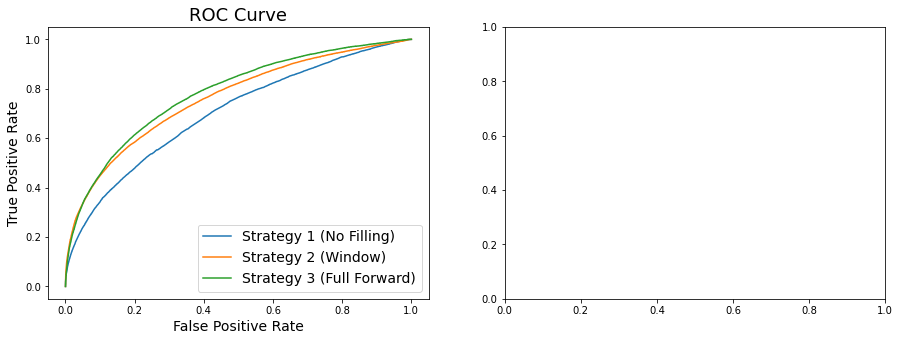

In [33]:
#ROC & Kappa curves
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(1,2, figsize=(15,5))

fpr_1, tpr_1, thres_1 = roc_curve(y_test, y_score1)
fpr_2, tpr_2, thres_2 = roc_curve(y_test, y_score2)
fpr_3, tpr_3, thres_3 = roc_curve(y_test, y_score3)
ax[0].plot(fpr_1, tpr_1)
ax[0].plot(fpr_2, tpr_2)
ax[0].plot(fpr_3, tpr_3)
ax[0].legend(['Strategy 1 (No Filling)', 'Strategy 2 (Window)', 'Strategy 3 (Full Forward)'], fontsize=14);
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[0].set_title('ROC Curve', fontsize=18)

fpr_1, kappa_1, thres_1 = kappa_curve(y_test, y_score1)
fpr_2, kappa_2, thres_2 = kappa_curve(y_test, y_score2)
fpr_3, kappa_3, thres_3 = kappa_curve(y_test, y_score3)
ax[1].plot(fpr_1, kappa_1)
ax[1].plot(fpr_2, kappa_2)
ax[1].plot(fpr_3, kappa_3)
ax[1].legend(['Strategy 1 (No Filling)', 'Strategy 2 (Window)', 'Strategy 3 (Full Forward)'], fontsize=14);
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel("Cohen's Kappa", fontsize=14)
ax[1].set_title("Cohen's Kappa Curve", fontsize=18)

# fig.savefig(os.path.join(figs_base_path,'ROC-Kappa-filling-strategies.png'),
#             dpi=200,
#             pad_inches=100)

Again, it seems strategy 3 is most effective, though the differences are modest compared to our strategy.